## Carregamento dos dados

In [1]:
import numpy as np
import torch
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

X_ = torch.load('../data/processed/X_.pt')
y_ = torch.load('../data/processed/y_.pt')

real_set = TensorDataset(X_, y_)

X_0 = torch.load('../data/processed/X_0.pt')
X_1 = torch.load('../data/processed/X_1.pt')
X_2 = torch.load('../data/processed/X_2.pt')
X_3 = torch.load('../data/processed/X_3.pt')

X_0 = torch.from_numpy(np.expand_dims(X_0, axis=1))
X_1 = torch.from_numpy(np.expand_dims(X_1, axis=1))
X_2 = torch.from_numpy(np.expand_dims(X_2, axis=1))
X_3 = torch.from_numpy(np.expand_dims(X_3, axis=1))

gen_set_0 = TensorDataset(X_0, torch.as_tensor(np.full(1296, 0)))
gen_set_1 = TensorDataset(X_1, torch.as_tensor(np.full(1296, 1)))
gen_set_2 = TensorDataset(X_2, torch.as_tensor(np.full(1296, 2)))
gen_set_3 = TensorDataset(X_3, torch.as_tensor(np.full(1296, 3)))

print(X_0.shape)
print(X_1.shape)
print(X_2.shape)
print(X_3.shape)
print(X_.shape)
print(y_.shape)

/home/matias/Mestrado/venv_BCI/venv_BCI/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


torch.Size([1296, 1, 22, 1125])
torch.Size([1296, 1, 22, 1125])
torch.Size([1296, 1, 22, 1125])
torch.Size([1296, 1, 22, 1125])
torch.Size([5184, 22, 1125])
torch.Size([5184])


## Definição do modelo da GAN

In [2]:
from torch import flatten
from torch import nn

In [3]:
class Generator(nn.Module):
    def __init__(self, inputDim=100, outputChannels=1):
        super(Generator, self).__init__()
        
        self.ct1 = nn.ConvTranspose2d(in_channels=inputDim, out_channels=128, kernel_size=(1, 140), stride=2, padding=0, bias=False)
        self.relu1 = nn.ReLU()
        self.batchNorm1 = nn.BatchNorm2d(128)
        
        self.ct2 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=(4, 4), stride=2, padding=0, bias=False)
        self.relu2 = nn.ReLU()
        self.batchNorm2 = nn.BatchNorm2d(64)
        
        self.ct3 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=(4, 1), stride=2, padding=0, bias=False)
        self.relu3 = nn.ReLU()
        self.batchNorm3 = nn.BatchNorm2d(32)
        
        self.ct4 = nn.ConvTranspose2d(in_channels=32, out_channels=outputChannels, kernel_size=(4, 1), stride=2, padding=0, bias=False)
        self.tanh = nn.Tanh()
        
    def forward(self, x):
        x = self.ct1(x)
        x = self.relu1(x)
        x = self.batchNorm1(x)
        
        x = self.ct2(x)
        x = self.relu2(x)
        x = self.batchNorm2(x)
        
        x = self.ct3(x)
        x = self.relu3(x)
        x = self.batchNorm3(x)
        
        x = self.ct4(x)
        output = self.tanh(x)
        
        return output

In [4]:
class Discriminator(nn.Module):
	def __init__(self, depth, alpha=0.2):
		super(Discriminator, self).__init__()
        
		self.conv1 = nn.Conv2d(in_channels=depth, out_channels=32, kernel_size=4, stride=2, padding=1)
		self.leakyRelu1 = nn.LeakyReLU(alpha, inplace=True)
        
		self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2, padding=1)
		self.leakyRelu2 = nn.LeakyReLU(alpha, inplace=True)
        
		self.fc1 = nn.Linear(in_features=89920, out_features=512)
		self.leakyRelu3 = nn.LeakyReLU(alpha, inplace=True)
        
		self.fc2 = nn.Linear(in_features=512, out_features=1)
		self.sigmoid = nn.Sigmoid()

	def forward(self, x):
		x = self.conv1(x)
		x = self.leakyRelu1(x)
        
		x = self.conv2(x)
		x = self.leakyRelu2(x)
        
		x = flatten(x, 1)
		x = self.fc1(x)
		x = self.leakyRelu3(x)
        
		x = self.fc2(x)
		output = self.sigmoid(x)
        
		return output

In [5]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
NUM_EPOCHS = 20
BATCH_SIZE = 128

In [6]:
dataloader_0 = DataLoader(dataset=gen_set_0, batch_size=128)
dataloader_1 = DataLoader(dataset=gen_set_1, batch_size=128)
dataloader_2 = DataLoader(dataset=gen_set_2, batch_size=128)
dataloader_3 = DataLoader(dataset=gen_set_3, batch_size=128)

In [7]:
from torch.optim import Adam
from torch.nn import BCELoss

stepsPerEpoch = len(dataloader_0.dataset) // BATCH_SIZE

print("[INFO] building generator...")
gen = Generator(inputDim=100, outputChannels=1)
gen.to(DEVICE)

print("[INFO] building discriminator...")
disc = Discriminator(depth=1)
disc.to(DEVICE)

genOpt = Adam(gen.parameters(), lr=0.0002, betas=(0.5, 0.999), weight_decay=0.0002 / NUM_EPOCHS)
discOpt = Adam(disc.parameters(), lr=0.0002, betas=(0.5, 0.999), weight_decay=0.0002 / NUM_EPOCHS)

criterion = BCELoss()

print("[INFO] starting training...")
benchmarkNoise = torch.randn(1296, 100, 1, 1, device=DEVICE)

realLabel = 1
fakeLabel = 0

[INFO] building generator...
[INFO] building discriminator...
[INFO] starting training...


In [8]:
from torchsummary import summary
summary(gen, (100, 1, 1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1          [-1, 128, 1, 140]       1,792,000
              ReLU-2          [-1, 128, 1, 140]               0
       BatchNorm2d-3          [-1, 128, 1, 140]             256
   ConvTranspose2d-4           [-1, 64, 4, 282]         131,072
              ReLU-5           [-1, 64, 4, 282]               0
       BatchNorm2d-6           [-1, 64, 4, 282]             128
   ConvTranspose2d-7          [-1, 32, 10, 563]           8,192
              ReLU-8          [-1, 32, 10, 563]               0
       BatchNorm2d-9          [-1, 32, 10, 563]              64
  ConvTranspose2d-10          [-1, 1, 22, 1125]             128
             Tanh-11          [-1, 1, 22, 1125]               0
Total params: 1,931,840
Trainable params: 1,931,840
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forw

In [9]:
summary(disc, (1, 22, 1125))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 32, 11, 562]             544
         LeakyReLU-2          [-1, 32, 11, 562]               0
            Conv2d-3           [-1, 64, 5, 281]          32,832
         LeakyReLU-4           [-1, 64, 5, 281]               0
            Linear-5                  [-1, 512]      46,039,552
         LeakyReLU-6                  [-1, 512]               0
            Linear-7                    [-1, 1]             513
           Sigmoid-8                    [-1, 1]               0
Total params: 46,073,441
Trainable params: 46,073,441
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.09
Forward/backward pass size (MB): 4.40
Params size (MB): 175.76
Estimated Total Size (MB): 180.25
----------------------------------------------------------------


## Geração dos dados sintéticos

In [10]:
for epoch in range(NUM_EPOCHS):
    print("[INFO] starting epoch {} of {}...".format(epoch + 1, NUM_EPOCHS))
    
    epochLossG = 0
    epochLossD = 0
    for x in dataloader_0:
        disc.zero_grad()
        
        images = x[0]
        images = images.to(DEVICE)
        
        bs =  images.size(0)
        labels = torch.full((bs,), realLabel, dtype=torch.float, device=DEVICE)
        
        output = disc(images).view(-1)
        
        errorReal = criterion(output, labels)
        
        errorReal.backward()
        
        noise = torch.randn(bs, 100, 1, 1, device=DEVICE)
        
        fake_0 = gen(noise)
        labels.fill_(fakeLabel)
        
        output = disc(fake_0.detach()).view(-1)
        errorFake = criterion(output, labels)
        
        errorFake.backward()
        
        errorD = errorReal + errorFake
        discOpt.step()
        
        gen.zero_grad()
        
        labels.fill_(realLabel)
        output = disc(fake_0).view(-1)
        
        errorG = criterion(output, labels)
        errorG.backward()
        
        genOpt.step()
        
        epochLossD += errorD
        epochLossG += errorG
        
    print("[INFO] Generator Loss: {:.4f}, Discriminator Loss: {:.4f}".format(epochLossG / stepsPerEpoch, epochLossD / stepsPerEpoch))
    if (epoch + 1) % 2 == 0:
        gen.eval()
        fake_0 = gen(benchmarkNoise)
        gen.train()

[INFO] starting epoch 1 of 20...
[INFO] Generator Loss: 4.5617, Discriminator Loss: 0.7297
[INFO] starting epoch 2 of 20...
[INFO] Generator Loss: 6.1080, Discriminator Loss: 0.0061
[INFO] starting epoch 3 of 20...
[INFO] Generator Loss: 6.0819, Discriminator Loss: 0.0152
[INFO] starting epoch 4 of 20...
[INFO] Generator Loss: 8.3954, Discriminator Loss: 0.0069
[INFO] starting epoch 5 of 20...
[INFO] Generator Loss: 8.7320, Discriminator Loss: 0.0005
[INFO] starting epoch 6 of 20...
[INFO] Generator Loss: 8.8144, Discriminator Loss: 0.0005
[INFO] starting epoch 7 of 20...
[INFO] Generator Loss: 9.0445, Discriminator Loss: 0.0005
[INFO] starting epoch 8 of 20...
[INFO] Generator Loss: 9.2582, Discriminator Loss: 0.0004
[INFO] starting epoch 9 of 20...
[INFO] Generator Loss: 9.5679, Discriminator Loss: 0.0003
[INFO] starting epoch 10 of 20...
[INFO] Generator Loss: 9.8370, Discriminator Loss: 0.0002
[INFO] starting epoch 11 of 20...
[INFO] Generator Loss: 10.1535, Discriminator Loss: 0.0

In [11]:
print(fake_0.shape)

torch.Size([1296, 1, 22, 1125])


In [12]:
size=(22, 1125)
fake_0 = fake_0.detach().cpu().view(-1, *size)
print(fake_0.shape)

torch.Size([1296, 22, 1125])


In [13]:
import gc

gen.cpu()
disc.cpu()
del gen, disc
gc.collect()
torch.cuda.empty_cache()

In [14]:
stepsPerEpoch = len(dataloader_0.dataset) // BATCH_SIZE

print("[INFO] building generator...")
gen = Generator(inputDim=100, outputChannels=1)
gen.to(DEVICE)

print("[INFO] building discriminator...")
disc = Discriminator(depth=1)
disc.to(DEVICE)

genOpt = Adam(gen.parameters(), lr=0.0002, betas=(0.5, 0.999), weight_decay=0.0002 / NUM_EPOCHS)
discOpt = Adam(disc.parameters(), lr=0.0002, betas=(0.5, 0.999), weight_decay=0.0002 / NUM_EPOCHS)

criterion = BCELoss()

print("[INFO] starting training...")
benchmarkNoise = torch.randn(1296, 100, 1, 1, device=DEVICE)

realLabel = 1
fakeLabel = 0

[INFO] building generator...
[INFO] building discriminator...
[INFO] starting training...


In [15]:
for epoch in range(NUM_EPOCHS):
    print("[INFO] starting epoch {} of {}...".format(epoch + 1, NUM_EPOCHS))
    
    epochLossG = 0
    epochLossD = 0
    for x in dataloader_1:
        disc.zero_grad()
        
        images = x[0]
        images = images.to(DEVICE)
        
        bs =  images.size(0)
        labels = torch.full((bs,), realLabel, dtype=torch.float, device=DEVICE)
        
        output = disc(images).view(-1)
        
        errorReal = criterion(output, labels)
        
        errorReal.backward()
        
        noise = torch.randn(bs, 100, 1, 1, device=DEVICE)
        
        fake_1 = gen(noise)
        labels.fill_(fakeLabel)
        
        output = disc(fake_1.detach()).view(-1)
        errorFake = criterion(output, labels)
        
        errorFake.backward()
        
        errorD = errorReal + errorFake
        discOpt.step()
        
        gen.zero_grad()
        
        labels.fill_(realLabel)
        output = disc(fake_1).view(-1)
        
        errorG = criterion(output, labels)
        errorG.backward()
        
        genOpt.step()
        
        epochLossD += errorD
        epochLossG += errorG
        
    print("[INFO] Generator Loss: {:.4f}, Discriminator Loss: {:.4f}".format(epochLossG / stepsPerEpoch, epochLossD / stepsPerEpoch))
    if (epoch + 1) % 2 == 0:
        gen.eval()
        fake_1 = gen(benchmarkNoise)
        gen.train()

[INFO] starting epoch 1 of 20...
[INFO] Generator Loss: 4.4851, Discriminator Loss: 0.7122
[INFO] starting epoch 2 of 20...
[INFO] Generator Loss: 6.0998, Discriminator Loss: 0.0066
[INFO] starting epoch 3 of 20...
[INFO] Generator Loss: 6.2901, Discriminator Loss: 0.0088
[INFO] starting epoch 4 of 20...
[INFO] Generator Loss: 7.7469, Discriminator Loss: 0.0020
[INFO] starting epoch 5 of 20...
[INFO] Generator Loss: 8.7957, Discriminator Loss: 0.0007
[INFO] starting epoch 6 of 20...
[INFO] Generator Loss: 9.4019, Discriminator Loss: 0.0004
[INFO] starting epoch 7 of 20...
[INFO] Generator Loss: 9.7055, Discriminator Loss: 0.0003
[INFO] starting epoch 8 of 20...
[INFO] Generator Loss: 9.8428, Discriminator Loss: 0.0003
[INFO] starting epoch 9 of 20...
[INFO] Generator Loss: 10.0283, Discriminator Loss: 0.0002
[INFO] starting epoch 10 of 20...
[INFO] Generator Loss: 10.2496, Discriminator Loss: 0.0002
[INFO] starting epoch 11 of 20...
[INFO] Generator Loss: 10.2868, Discriminator Loss: 0

In [16]:
print(fake_1.shape)

torch.Size([1296, 1, 22, 1125])


In [17]:
fake_1 = fake_1.detach().cpu().view(-1, *size)
print(fake_1.shape)

torch.Size([1296, 22, 1125])


In [18]:
gen.cpu()
disc.cpu()
del gen, disc
gc.collect()
torch.cuda.empty_cache()

In [19]:
stepsPerEpoch = len(dataloader_0.dataset) // BATCH_SIZE

print("[INFO] building generator...")
gen = Generator(inputDim=100, outputChannels=1)
gen.to(DEVICE)

print("[INFO] building discriminator...")
disc = Discriminator(depth=1)
disc.to(DEVICE)

genOpt = Adam(gen.parameters(), lr=0.0002, betas=(0.5, 0.999), weight_decay=0.0002 / NUM_EPOCHS)
discOpt = Adam(disc.parameters(), lr=0.0002, betas=(0.5, 0.999), weight_decay=0.0002 / NUM_EPOCHS)

criterion = BCELoss()

print("[INFO] starting training...")
benchmarkNoise = torch.randn(1296, 100, 1, 1, device=DEVICE)

realLabel = 1
fakeLabel = 0

[INFO] building generator...
[INFO] building discriminator...
[INFO] starting training...


In [20]:
for epoch in range(NUM_EPOCHS):
    print("[INFO] starting epoch {} of {}...".format(epoch + 1, NUM_EPOCHS))
    
    epochLossG = 0
    epochLossD = 0
    for x in dataloader_2:
        disc.zero_grad()
        
        images = x[0]
        images = images.to(DEVICE)
        
        bs =  images.size(0)
        labels = torch.full((bs,), realLabel, dtype=torch.float, device=DEVICE)
        
        output = disc(images).view(-1)
        
        errorReal = criterion(output, labels)
        
        errorReal.backward()
        
        noise = torch.randn(bs, 100, 1, 1, device=DEVICE)
        
        fake_2 = gen(noise)
        labels.fill_(fakeLabel)
        
        output = disc(fake_2.detach()).view(-1)
        errorFake = criterion(output, labels)
        
        errorFake.backward()
        
        errorD = errorReal + errorFake
        discOpt.step()
        
        gen.zero_grad()
        
        labels.fill_(realLabel)
        output = disc(fake_2).view(-1)
        
        errorG = criterion(output, labels)
        errorG.backward()
        
        genOpt.step()
        
        epochLossD += errorD
        epochLossG += errorG
        
    print("[INFO] Generator Loss: {:.4f}, Discriminator Loss: {:.4f}".format(epochLossG / stepsPerEpoch, epochLossD / stepsPerEpoch))
    if (epoch + 1) % 2 == 0:
        gen.eval()
        fake_2 = gen(benchmarkNoise)
        gen.train()

[INFO] starting epoch 1 of 20...
[INFO] Generator Loss: 5.7113, Discriminator Loss: 0.6865
[INFO] starting epoch 2 of 20...
[INFO] Generator Loss: 6.8995, Discriminator Loss: 0.0036
[INFO] starting epoch 3 of 20...
[INFO] Generator Loss: 6.5370, Discriminator Loss: 0.0152
[INFO] starting epoch 4 of 20...
[INFO] Generator Loss: 5.6322, Discriminator Loss: 3.7719
[INFO] starting epoch 5 of 20...
[INFO] Generator Loss: 4.7183, Discriminator Loss: 0.0238
[INFO] starting epoch 6 of 20...
[INFO] Generator Loss: 5.2902, Discriminator Loss: 0.0124
[INFO] starting epoch 7 of 20...
[INFO] Generator Loss: 6.0024, Discriminator Loss: 0.0062
[INFO] starting epoch 8 of 20...
[INFO] Generator Loss: 6.3687, Discriminator Loss: 0.0048
[INFO] starting epoch 9 of 20...
[INFO] Generator Loss: 6.9711, Discriminator Loss: 0.0028
[INFO] starting epoch 10 of 20...
[INFO] Generator Loss: 7.4863, Discriminator Loss: 0.0015
[INFO] starting epoch 11 of 20...
[INFO] Generator Loss: 7.7686, Discriminator Loss: 0.00

In [21]:
print(fake_2.shape)

torch.Size([1296, 1, 22, 1125])


In [22]:
fake_2 = fake_2.detach().cpu().view(-1, *size)
print(fake_2.shape)

torch.Size([1296, 22, 1125])


In [23]:
gen.cpu()
disc.cpu()
del gen, disc
gc.collect()
torch.cuda.empty_cache()

In [24]:
stepsPerEpoch = len(dataloader_0.dataset) // BATCH_SIZE

print("[INFO] building generator...")
gen = Generator(inputDim=100, outputChannels=1)
gen.to(DEVICE)

print("[INFO] building discriminator...")
disc = Discriminator(depth=1)
disc.to(DEVICE)

genOpt = Adam(gen.parameters(), lr=0.0002, betas=(0.5, 0.999), weight_decay=0.0002 / NUM_EPOCHS)
discOpt = Adam(disc.parameters(), lr=0.0002, betas=(0.5, 0.999), weight_decay=0.0002 / NUM_EPOCHS)

criterion = BCELoss()

print("[INFO] starting training...")
benchmarkNoise = torch.randn(1296, 100, 1, 1, device=DEVICE)

realLabel = 1
fakeLabel = 0

[INFO] building generator...
[INFO] building discriminator...
[INFO] starting training...


In [25]:
for epoch in range(NUM_EPOCHS):
    print("[INFO] starting epoch {} of {}...".format(epoch + 1, NUM_EPOCHS))
    
    epochLossG = 0
    epochLossD = 0
    for x in dataloader_3:
        disc.zero_grad()
        
        images = x[0]
        images = images.to(DEVICE)
        
        bs =  images.size(0)
        labels = torch.full((bs,), realLabel, dtype=torch.float, device=DEVICE)
        
        output = disc(images).view(-1)
        
        errorReal = criterion(output, labels)
        
        errorReal.backward()
        
        noise = torch.randn(bs, 100, 1, 1, device=DEVICE)
        
        fake_3 = gen(noise)
        labels.fill_(fakeLabel)
        
        output = disc(fake_3.detach()).view(-1)
        errorFake = criterion(output, labels)
        
        errorFake.backward()
        
        errorD = errorReal + errorFake
        discOpt.step()
        
        gen.zero_grad()
        
        labels.fill_(realLabel)
        output = disc(fake_3).view(-1)
        
        errorG = criterion(output, labels)
        errorG.backward()
        
        genOpt.step()
        
        epochLossD += errorD
        epochLossG += errorG
        
    print("[INFO] Generator Loss: {:.4f}, Discriminator Loss: {:.4f}".format(epochLossG / stepsPerEpoch, epochLossD / stepsPerEpoch))
    if (epoch + 1) % 2 == 0:
        gen.eval()
        fake_3 = gen(benchmarkNoise)
        gen.train()

[INFO] starting epoch 1 of 20...
[INFO] Generator Loss: 5.9312, Discriminator Loss: 0.6679
[INFO] starting epoch 2 of 20...
[INFO] Generator Loss: 7.3045, Discriminator Loss: 0.0031
[INFO] starting epoch 3 of 20...
[INFO] Generator Loss: 6.1129, Discriminator Loss: 0.0108
[INFO] starting epoch 4 of 20...
[INFO] Generator Loss: 7.8928, Discriminator Loss: 0.2585
[INFO] starting epoch 5 of 20...
[INFO] Generator Loss: 7.6394, Discriminator Loss: 0.0014
[INFO] starting epoch 6 of 20...
[INFO] Generator Loss: 7.2660, Discriminator Loss: 0.0019
[INFO] starting epoch 7 of 20...
[INFO] Generator Loss: 7.7451, Discriminator Loss: 0.0013
[INFO] starting epoch 8 of 20...
[INFO] Generator Loss: 8.2249, Discriminator Loss: 0.0009
[INFO] starting epoch 9 of 20...
[INFO] Generator Loss: 8.4009, Discriminator Loss: 0.0007
[INFO] starting epoch 10 of 20...
[INFO] Generator Loss: 8.5417, Discriminator Loss: 0.0007
[INFO] starting epoch 11 of 20...
[INFO] Generator Loss: 9.0276, Discriminator Loss: 0.00

In [26]:
print(fake_3.shape)

torch.Size([1296, 1, 22, 1125])


In [27]:
fake_3 = fake_3.detach().cpu().view(-1, *size)
print(fake_3.shape)

torch.Size([1296, 22, 1125])


In [28]:
gen.cpu()
disc.cpu()
del gen, disc
gc.collect()
torch.cuda.empty_cache()

## Processamento dos dados sintéticos para classificação

In [29]:
fake = torch.cat((fake_0, fake_1, fake_2, fake_3), 0)
y_fake = torch.cat((torch.as_tensor(np.full(1296, 0)), torch.as_tensor(np.full(1296, 1)), torch.as_tensor(np.full(1296, 2)), torch.as_tensor(np.full(1296, 3))), 0)
print(fake.shape)
print(y_fake.shape)

torch.Size([5184, 22, 1125])
torch.Size([5184])


In [30]:
import numpy as np
from scipy import signal

window_size = 128
overlap = 64
fft_size = 128
sampling_rate = 250

spectrograms_spectrogram = []

for i in range(fake.shape[0]):
    f, t, spectrogram = signal.spectrogram(fake[i, :], fs=sampling_rate, window='hann', nperseg=window_size, noverlap=overlap, nfft=fft_size)
    spectrograms_spectrogram.append(spectrogram)

spectrograms_spectrogram = np.array(spectrograms_spectrogram)

(5184, 22, 65, 16)


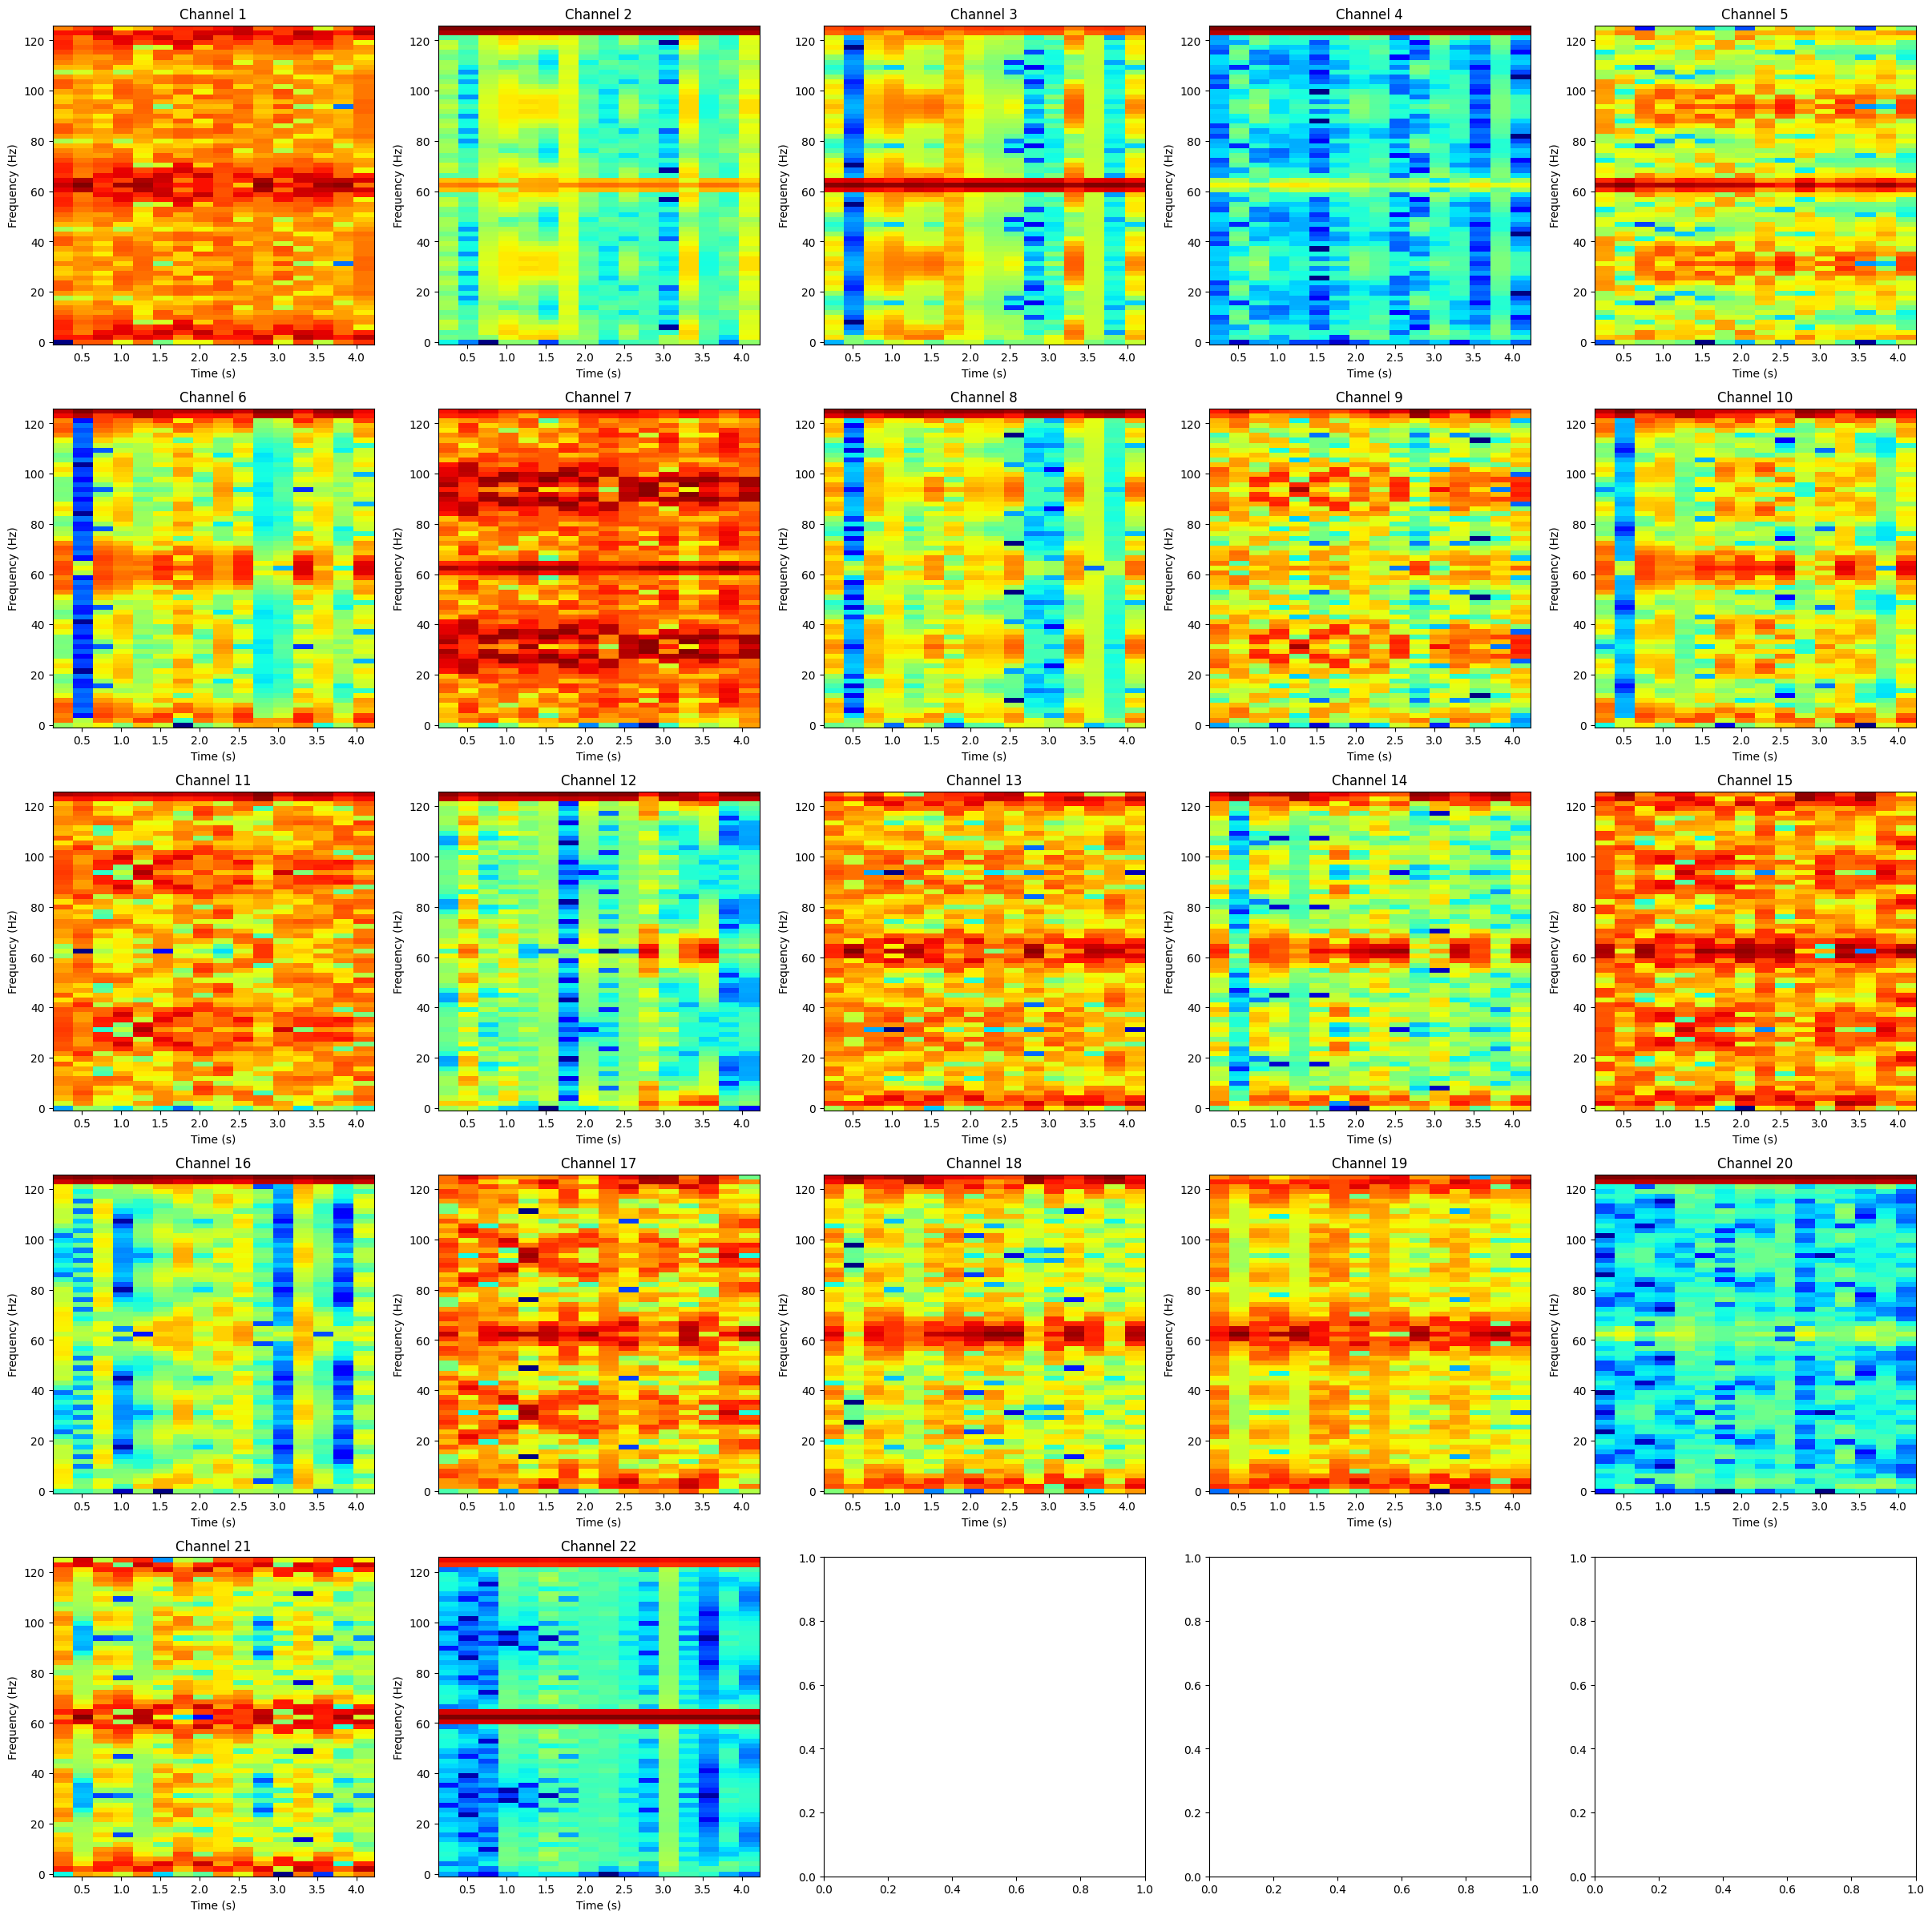

In [34]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(30, 30))
for i in range(5):
    for j in range(5):
        axs[i,j].pcolormesh(t, f, 20*np.log10(abs(spectrograms_spectrogram[0][i*5+j, :, :])), cmap='jet')
        axs[i,j].set_title('Channel ' + str(i*5+j+1))
        axs[i,j].set_xlabel('Time (s)')
        axs[i,j].set_ylabel('Frequency (Hz)')
        if(i*5+j == 21):
            break
    if(i*5+j == 21):
        break

print(spectrograms_spectrogram.shape)
plt.show()

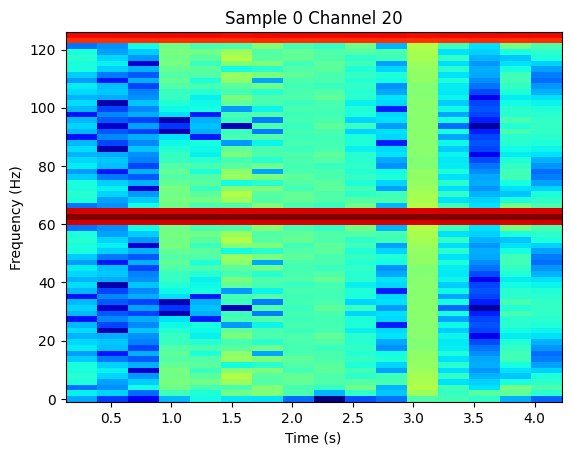

In [36]:
plt.pcolormesh(t, f, 20*np.log10(abs(spectrograms_spectrogram[0][21, :, :])), cmap='jet')
plt.title('Sample 0 Channel 20')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.show()

In [32]:
fake_set = TensorDataset(fake, y_fake)

In [33]:
from torch.utils.data import random_split

fake_fulltrainset, fake_evalset = random_split(fake_set, [2592, 2592])
fake_trainset, fake_testset = random_split(fake_fulltrainset, [1728, 864])
real_fulltrainset, real_evalset = random_split(real_set, [2592, 2592])
real_trainset, real_testset = random_split(real_fulltrainset, [1728, 864])

## Definição do modelo do classificador

In [34]:
from braindecode.util import set_random_seeds
from braindecode.models import EEGNetv4

cuda = torch.cuda.is_available()
device = 'cuda' if cuda else 'cpu'
if cuda:
    torch.backends.cudnn.benchmark = False

seed = 20200220
set_random_seeds(seed=seed, cuda=cuda)

n_classes = 4
n_chans = 22
input_window_samples = 1125
F1, D = 4, 2
kernel_length = 64

model = EEGNetv4(
    n_chans,
    n_classes,
    input_window_samples=input_window_samples,
    final_conv_length='auto',
    F1=8,
    D=2,
    F2=F1*D,
    kernel_length=kernel_length,
    drop_prob=0.5
)
model.to(device);

## Treinamento do classificador com dados reais

In [35]:
from skorch.helper import predefined_split
from skorch.callbacks import LRScheduler
from braindecode import EEGClassifier

batch_size = 32
n_epochs = 50

real_clf = EEGClassifier(
    model,
    criterion=torch.nn.NLLLoss,
    optimizer=torch.optim.Adam,
    train_split=predefined_split(real_testset),
    batch_size=batch_size,
    callbacks=[
        "accuracy", ("lr_scheduler", LRScheduler('CosineAnnealingLR', T_max=n_epochs - 1)),
    ],
    device=device,
)
real_clf.fit(real_trainset, y=None, epochs=n_epochs);

  epoch    train_accuracy    train_loss    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  ----------------  ------------  ------  ------
      1            0.3530        1.4163            0.3079        1.3656  0.0100  0.7835
      2            0.3704        1.3618            0.3600        1.3495  0.0100  0.6573
      3            0.4207        1.3190            0.3750        1.2904  0.0100  0.6577
      4            0.4427        1.2944            0.3877        1.2816  0.0099  0.6589
      5            0.4502        1.2504            0.3935        1.3281  0.0098  0.6591
      6            0.5579        1.2152            0.4618        1.1640  0.0097  0.6626
      7            0.5631        1.2020            0.4780        1.1362  0.0096  0.6718
      8            0.6019        1.1687            0.5197        1.0897  0.0095  0.6689
      9            0.5816        1.1610            0.4942        1.0969  0.0094  0.6608
     10            0.5150       

In [36]:
print(f"Mean Accuracy: {np.mean(real_clf.predict(real_evalset) == [y for X,y in real_evalset])*100:.2f}%")

Mean Accuracy: 61.19%


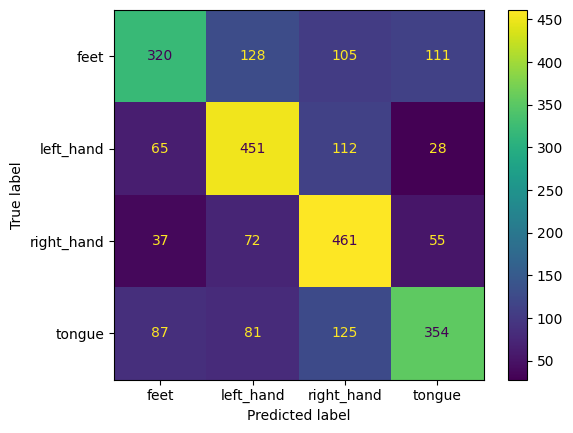

In [41]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

trtr = real_clf.predict(real_evalset)

conf_matrix = confusion_matrix(
    y_true=[y for _,y in real_evalset],
    y_pred=trtr,
    labels=list([0, 1, 2, 3]),
)

disp = ConfusionMatrixDisplay(
    confusion_matrix=conf_matrix, 
    display_labels=list(["feet", "left_hand", "right_hand", "tongue"])
)
disp.plot()
plt.show();

In [42]:
print(f"Mean Accuracy: {np.mean(real_clf.predict(fake_evalset) == [y for X,y in fake_evalset])*100:.2f}%")

Mean Accuracy: 24.50%


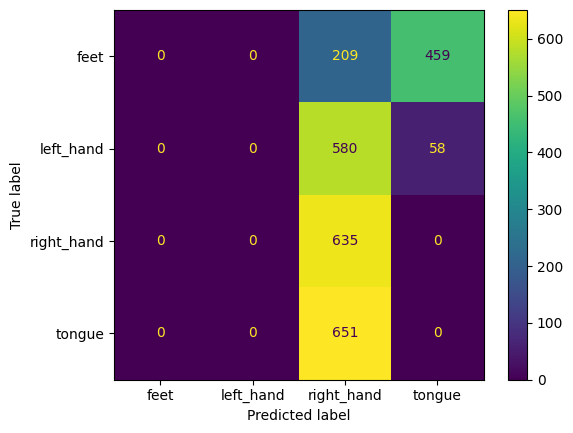

In [43]:
trts = real_clf.predict(fake_evalset)

conf_matrix = confusion_matrix(
    y_true=[y for _,y in fake_evalset],
    y_pred=trts,
    labels=list([0, 1, 2, 3]),
)

disp = ConfusionMatrixDisplay(
    confusion_matrix=conf_matrix, 
    display_labels=list(["feet", "left_hand", "right_hand", "tongue"])
)
disp.plot()
plt.show();

## Treinamento do classificador com dados sintéticos

In [44]:
fake_clf = EEGClassifier(
    model,
    criterion=torch.nn.NLLLoss,
    optimizer=torch.optim.Adam,
    train_split=predefined_split(fake_testset),
    batch_size=batch_size,
    callbacks=[
        "accuracy", ("lr_scheduler", LRScheduler('CosineAnnealingLR', T_max=n_epochs - 1)),
    ],
    device=device,
)
fake_clf.fit(fake_trainset, y=None, epochs=n_epochs);

  epoch    train_accuracy    train_loss    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  ----------------  ------------  ------  ------
      1            0.5735        0.1351            0.6076        1.0178  0.0100  0.7308
      2            0.4890        0.0004            0.5116        1.5104  0.0100  0.6575
      3            0.4919        0.0003            0.5127        1.5249  0.0100  0.6636
      4            0.5995        0.0002            0.6296        1.2596  0.0099  0.6573
      5            0.7402        0.0001            0.7546        0.7909  0.0098  0.6558
      6            0.7402        0.0001            0.7546        0.3441  0.0097  0.6515
      7            1.0000        0.0001            1.0000        0.0657  0.0096  0.6538
      8            1.0000        0.0001            1.0000        0.0084  0.0095  0.6565
      9            1.0000        0.0000            1.0000        0.0008  0.0094  0.6551
     10            1.0000       

In [45]:
print(f"Mean Accuracy: {np.mean(fake_clf.predict(real_evalset) == [y for X,y in real_evalset])*100:.2f}%")

Mean Accuracy: 26.20%


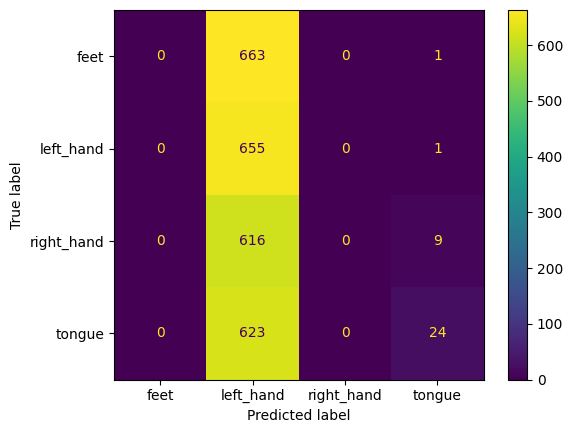

In [46]:
tstr = real_clf.predict(real_evalset)

conf_matrix = confusion_matrix(
    y_true=[y for _,y in real_evalset],
    y_pred=tstr,
    labels=list([0, 1, 2, 3]),
)

disp = ConfusionMatrixDisplay(
    confusion_matrix=conf_matrix, 
    display_labels=list(["feet", "left_hand", "right_hand", "tongue"])
)
disp.plot()
plt.show();

In [47]:
print(f"Mean Accuracy: {np.mean(fake_clf.predict(fake_evalset) == [y for X,y in fake_evalset])*100:.2f}%")

Mean Accuracy: 100.00%


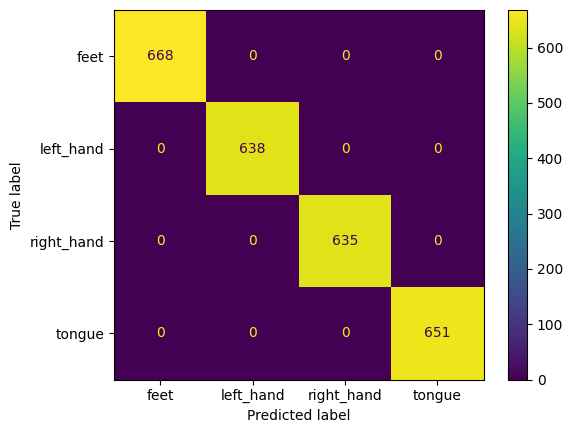

In [48]:
tsts = real_clf.predict(fake_evalset)

conf_matrix = confusion_matrix(
    y_true=[y for _,y in fake_evalset],
    y_pred=tsts,
    labels=list([0, 1, 2, 3]),
)

disp = ConfusionMatrixDisplay(
    confusion_matrix=conf_matrix, 
    display_labels=list(["feet", "left_hand", "right_hand", "tongue"])
)
disp.plot()
plt.show();

## Distância euclidiana entre os dados reais e sintéticos

In [35]:
real = X_.view(-1, *size)

In [36]:
torch.norm(real-fake, 2)

tensor(44012.6172)